In [37]:
#    Copyright 2023 Atick Faisal

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#        http://www.apache.org/licenses/LICENSE-2.0

#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
PATH = os.path.join(os.getcwd(), '../dataset/cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 1000 files belonging to 2 classes.


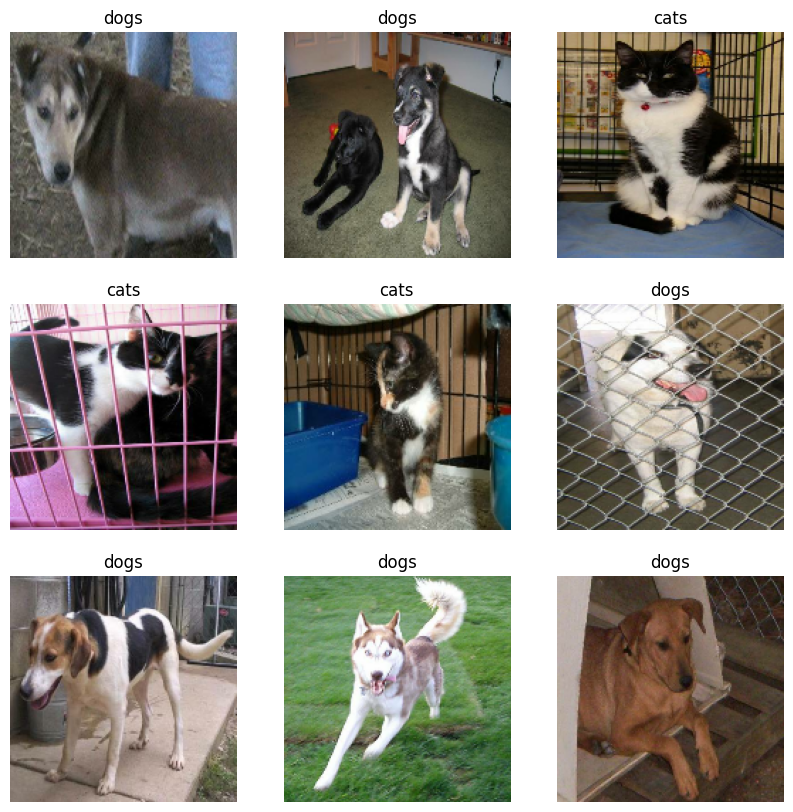

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' %
      tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' %
      tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

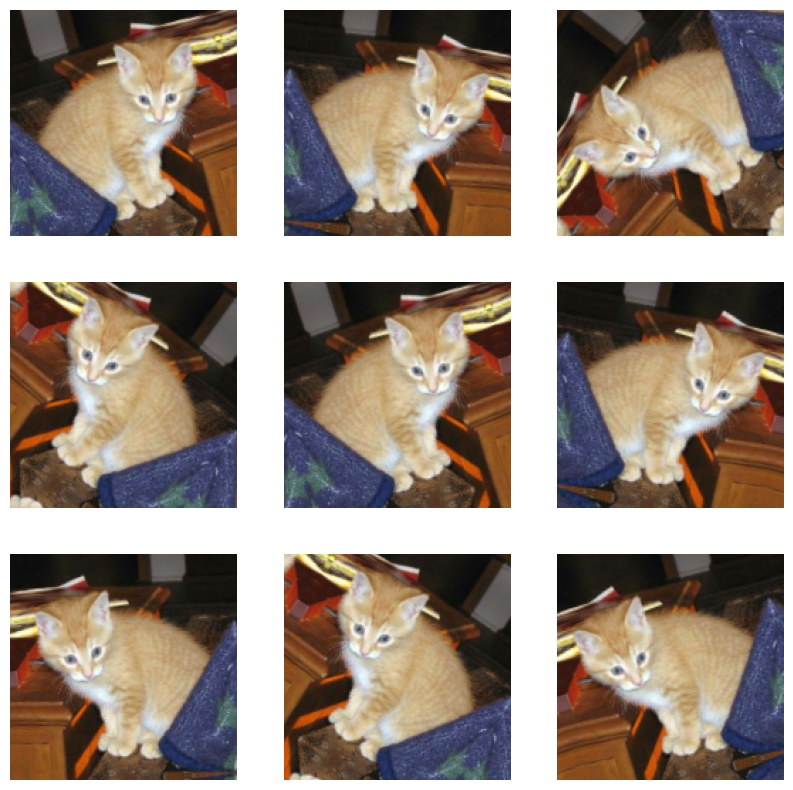

In [9]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [14]:
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [20]:
len(model.trainable_variables)

2

In [22]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')]
)

In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 5s 142ms/step - loss: 0.8006 - accuracy: 0.4715


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.47


In [25]:
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset
)

Epoch 1/10
63/63 [==============================] - 17s 241ms/step - loss: 0.7143 - accuracy: 0.5840 - val_loss: 0.5455 - val_accuracy: 0.7265
Epoch 2/10
63/63 [==============================] - 18s 280ms/step - loss: 0.5367 - accuracy: 0.7240 - val_loss: 0.4056 - val_accuracy: 0.8626
Epoch 3/10
63/63 [==============================] - 20s 323ms/step - loss: 0.4364 - accuracy: 0.8070 - val_loss: 0.3086 - val_accuracy: 0.9109
Epoch 4/10
63/63 [==============================] - 21s 332ms/step - loss: 0.3518 - accuracy: 0.8605 - val_loss: 0.2563 - val_accuracy: 0.9344
Epoch 5/10
63/63 [==============================] - 19s 306ms/step - loss: 0.3221 - accuracy: 0.8765 - val_loss: 0.2115 - val_accuracy: 0.9554
Epoch 6/10
63/63 [==============================] - 21s 327ms/step - loss: 0.2827 - accuracy: 0.8980 - val_loss: 0.1871 - val_accuracy: 0.9530
Epoch 7/10
63/63 [==============================] - 20s 324ms/step - loss: 0.2735 - accuracy: 0.8915 - val_loss: 0.1674 - val_accuracy: 0.9542

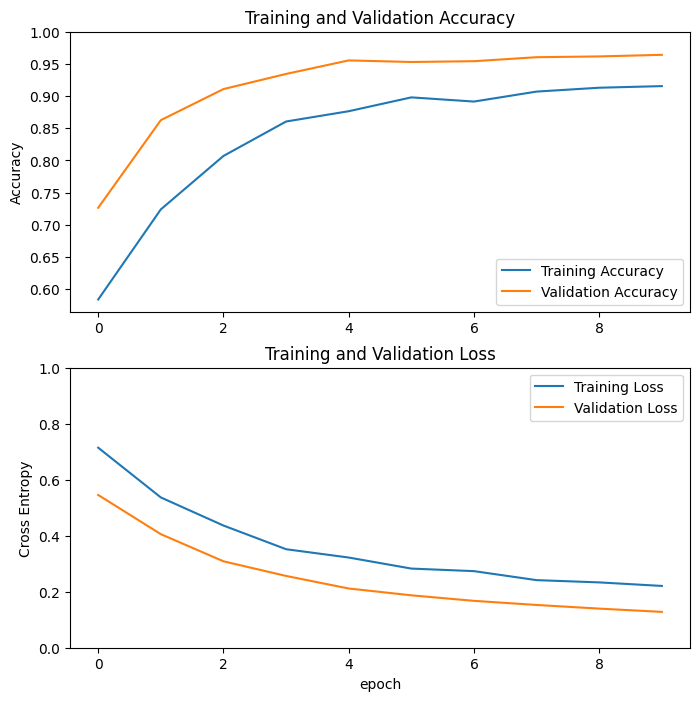

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [29]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')]
)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [31]:
len(model.trainable_variables)

56

In [32]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset
)

Epoch 10/20
63/63 [==============================] - 23s 322ms/step - loss: 0.1555 - accuracy: 0.9355 - val_loss: 0.0667 - val_accuracy: 0.9790
Epoch 11/20
63/63 [==============================] - 21s 332ms/step - loss: 0.1276 - accuracy: 0.9500 - val_loss: 0.0411 - val_accuracy: 0.9876
Epoch 12/20
63/63 [==============================] - 22s 344ms/step - loss: 0.1068 - accuracy: 0.9555 - val_loss: 0.0549 - val_accuracy: 0.9790
Epoch 13/20
63/63 [==============================] - 21s 327ms/step - loss: 0.0848 - accuracy: 0.9670 - val_loss: 0.0402 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 21s 327ms/step - loss: 0.0928 - accuracy: 0.9640 - val_loss: 0.0356 - val_accuracy: 0.9876
Epoch 15/20
63/63 [==============================] - 21s 330ms/step - loss: 0.0919 - accuracy: 0.9635 - val_loss: 0.0401 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 21s 330ms/step - loss: 0.0795 - accuracy: 0.9710 - val_loss: 0.0399 - val_accuracy:

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

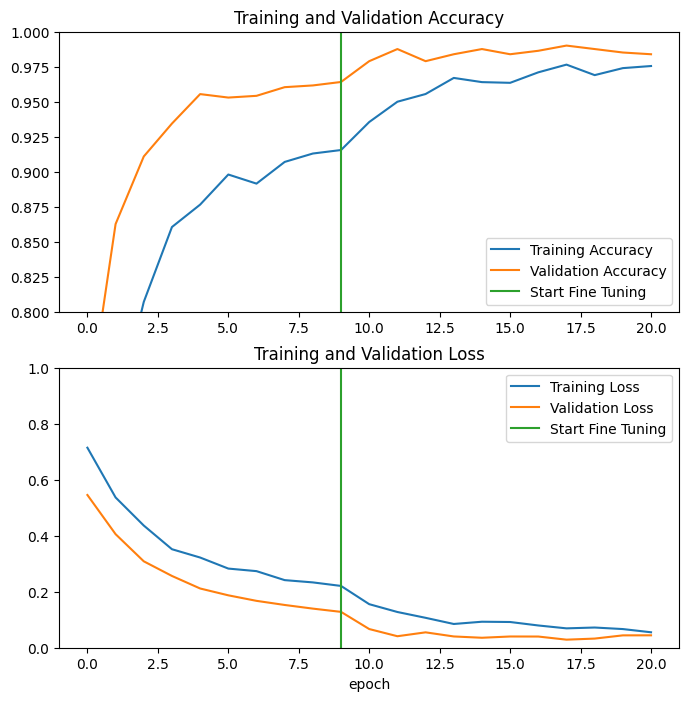

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 191ms/step - loss: 0.0245 - accuracy: 0.9844
Test accuracy : 0.984375


Predictions:
 [0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]
Labels:
 [0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0]


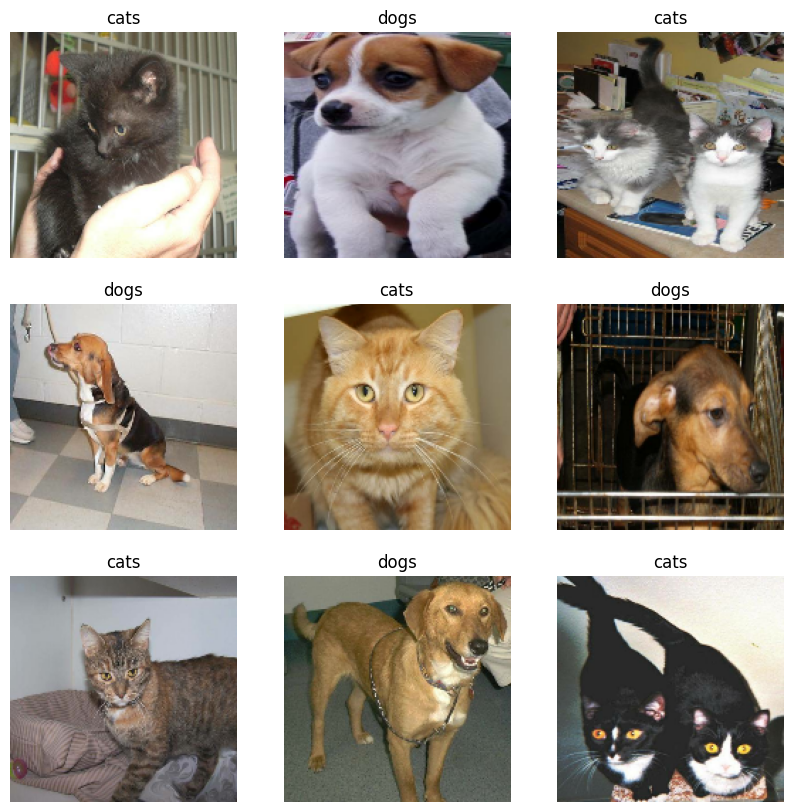

In [36]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

### SAVE MODEL

In [38]:
model_path = os.path.join(os.getcwd(), '../models/cats_and_dogs')
model.save(model_path)

INFO:tensorflow:Assets written to: /home/ai/Python/Jetpack-AI-Starter/src/../models/cats_and_dogs/assets


INFO:tensorflow:Assets written to: /home/ai/Python/Jetpack-AI-Starter/src/../models/cats_and_dogs/assets
